# Chapter 1: Introduction
Re-implementing fastai code. This chapter gives a high-level overview of things, with several examples using SoTA models. 

## Setup
See the [fastbook GitHub repo](https://github.com/fastai/fastbook) for more details

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 35.4 MB/s 
     |████████████████████████████████| 1.2 MB 14.9 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 51 kB 299 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

## Image classification

Ordinarily it's bad practice to do `from X import *` but fastai is designed to be efficient even when doing this. 

The following code does three things: 
1. Downloads the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)
2. Downloads a pretrained model
3. Fine-tunes the pretrained model using transfer learning



In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images' # downloads the PETS dataset

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224)
)

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.168349,0.020509,0.004060,01:36


epoch,train_loss,valid_loss,error_rate,time
0,0.051893,0.010496,0.002030,02:10


### Things to note
Good coding practice: we're calling a path *object*, not just a string!

There are two kinds of transforms that we're interested in: 
1. `item_tfms` are applied to each item
2. `batch_tfms` are applied to a batch of items at a time - fast, parallelisable

`valid_pct=0.2` means that we use 20% of the data for the validation set.

`seed=42` sets the random seed to the same value each time, such that we get the same validation set each time we run it (good for consistency during testing)

## Image segmentation

In [5]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,3.126963,2.383143,00:04


epoch,train_loss,valid_loss,time
0,1.871043,1.630483,00:04
1,1.621743,1.434431,00:04
2,1.462210,1.339497,00:04
3,1.329279,1.127423,00:04
4,1.204406,0.997827,00:04
5,1.091880,0.866237,00:04
6,0.996600,0.861343,00:04
7,0.918430,0.838886,00:04


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


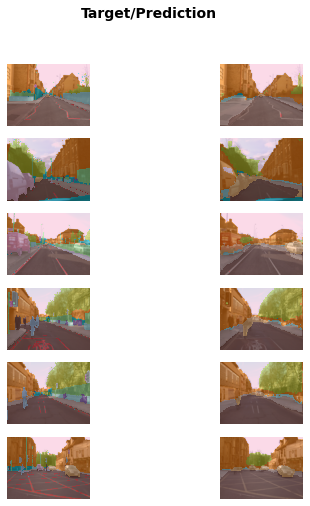

In [6]:
learn.show_results(max_n=6, figsize=(7,8))

## Natural Language Processing

In [7]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid="test")
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.466543,0.397557,0.820560,07:09


epoch,train_loss,valid_loss,accuracy,time
0,0.303623,0.242062,0.899280,13:58
1,0.258479,0.205452,0.921040,13:58
2,0.193521,0.185315,0.928800,13:58
3,0.142719,0.190255,0.930520,13:59


If this takes up too much memory, then try reducing the batch size `bs`. 

In [9]:
learn.predict("I really liked that movie!")
# learn.predict("Are transformer circuits interpretable?")
# learn.predict("今日は")
# learn.predict("안녕하세요")

('pos', TensorText(1), TensorText([2.7094e-06, 1.0000e+00]))

For all of the above, there are a few key steps:
- Import
- Load data (using a dataloader)
- Train a model (or download a pretrained one then fine-tune)
- Predict

These are all pretty standard things to do in ML.

You can also learn more about a fastai method using the `doc` function. 

In [10]:
doc(learn.predict)

## Tabular data: Predicting income

In [11]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

Notice that we had to mention which columns are categorical and which are continuous. 

Data in tables is usually is less likely to have an appropriate pretrained model, so we'll need to train from scratch. For this we use `fit_one_cycle` rather than `fine_tune`.

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.390864,0.351896,0.841984,00:07
1,0.361216,0.345328,0.843673,00:07
2,0.359025,0.338426,0.848127,00:07


## Tabular data: Predicting movie ratings

In [14]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.497539,1.424132,00:00


epoch,train_loss,valid_loss,time
0,1.362912,1.368166,00:00
1,1.274229,1.197982,00:00
2,1.029975,0.898914,00:00
3,0.806043,0.753159,00:00
4,0.690520,0.718574,00:00
5,0.651968,0.709240,00:00
6,0.615707,0.703566,00:00
7,0.591686,0.701510,00:00
8,0.599095,0.700377,00:00
9,0.592934,0.700309,00:00


In this case the output is continuous, so we need to specify the range of the target using `y_range`. 

In [15]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,13.0,50.0,4.0,3.922384
1,95.0,21.0,3.0,3.657287
2,60.0,1.0,4.5,4.174328
3,53.0,50.0,5.0,4.149423
4,4.0,61.0,5.0,4.241913
5,59.0,14.0,3.5,4.671744
6,49.0,90.0,4.0,4.148612
7,95.0,81.0,4.0,4.200567
8,35.0,45.0,3.5,3.222820


## Questionnaire

1. **What was the name of the first device that was based on the principle of the artifical neuron?**  
The perceptron

1. **Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?**  
Architectures and states, together with rules for activations, propagation and learning, all within a particular environment. 

1. **What were the two theoretical misunderstandings that held back the field of neural networks?**  
(1) conflating "simple perceptrons cannot even learn simple functions like XOR" with "all perceptron models with however many layers cannot learn simple functions". (2) one layer is all you need in *theory*, with infinite width, but isn't a good idea in practice

1. **What is a GPU?**  
Graphical processing unit, kind of like a "specialised CPU" that does lots of matrix calculations, making it good for deep learning. 

1. **Why is it hard to use a traditional computer program to recognize images in a photo?**  
We don't know how to specify the task of image recognition such that we could implement it in code.

1. **What did Samuel mean by "weight assignment"?**  
A set of values for the variables of a model, "what the current weights are". These help control the output, and are updated through training.

1. **What term do we normally use in deep learning for what Samuel called "weights"?**  
Parameters  

1. **Why is it hard to understand why a deep learning model makes a particular prediction?**  
The parameters are often hidden, or may not correspond to easily interpretable features. Moreover, this is done automatically by the model, rather than being "hand-crafted". 

1. **What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?**  
The universal approximation theorem

1. **What do you need in order to train a model?** 
(Labelled) data, a suitable algorithm, compute 

1. **How could a feedback loop impact the rollout of a predictive policing model?**  
It biases attention to be focused more towards areas where more arrests are made *in the dataset*, but not necessarily in practice. 

1. **Do we always have to use 224x224-pixel images with the cat recognition model?**  
No - 224 pixels is just common practice historically. Other sizes also work - larger sizes give better results, but require more compute. 

1. **What is the difference between classification and regression?**  
Classificiation gives a discrete output from a set of classes, regression gives a continuous output

1. **What is a validation set? What is a test set? Why do we need them?**  
A validation set is a hidden set of data used to measure model performance before deployment, and improve the model accuracy. The test set is another hidden set that isn't used to improve the model, just to evaluate it. Neither of these are used for training the model. These help check model accuracy and prevent overfitting - training loss keeps decreasing and may eventually overfit, but validation loss (because the validation set is disjoint) helps spot this. The validation set prevents overfitting on the training set, and the test set prevents overfitting on the validation set. 

1. **What will fastai do if you don't provide a validation set?**  
It creates a validation set automatically, with a default `valid_pct` of `0.2`. 

1. **Can we always use a random sample for a validation set? Why or why not?**  
We "can", but it's probably a bad idea. If we split the dataset such that sometimes the model is trained on validations set data in another run, then this leads to contamination and defeats the purpose of splitting the sets into validation and training sets. Furthermore, using different validation sets makes it hard to determine whether the model is actually improving, or if changes to the performance are due to changes in the datasets. 

1. **What is overfitting? Provide an example.**  
Fitting to noise rather than genuine patterns in the data, e.g. due to excessive model complexity. 

1. **What is a metric? How does it differ from "loss"?**
A metric is a functino that measures the quality of the model predictions using the validation set. It's not the same as loss, because it's defined to be human-readable, whereas loss is used to help update weights using gradient descent.

1. **How can pretrained models help?**  
It allows us to train more accurate models faster, with less data, less time, and less money. 

1. **What is the "head" of a model?**  
The last layer/part of a pretrained model. This is replaced with a randomly initialised layer for transfer learning, then fine-tuned. 

1. **What kinds of features do the early layers of a CNN find? How about the later layers?**  
Early layers find low-level features, later layers find higher-level ones. 

1. **Are image models only useful for photos?**  
Nope! Just convert the data you're interested in into image data. 

1. **What is an "architecture"?**  
The structure of the model in question. 

1. **What is segmentation?**  
Drawing a border around objects in images. 

1. **What is `y_range` used for? When do we need it?**  
It sets a bound on the possible target values

1. **What are "hyperparameters"?**  
Parameters that control parameters (i.e. parameters that control the training process)

1. **What's the best way to avoid failures when using AI in an organization?**  
Properly use validation and test sets - split the data before training, and make sure it is never seen during training. Then test it!

## Further Research

1. **Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?**  
It's specialised for matrix operations, and is also good for parallelising operations (e.g. minibatches in minibatch gradient descent). This makes it more efficient for deep learning. A CPU is more general (less about matrix operations) and thus does not have an architecture that is as suited for deep learning. 